In [2]:
# Install required packages for quantum error correction
!pip install qiskit qiskit-aer matplotlib numpy pandas pylatexenc

# Verify installation
import qiskit
print(f"Qiskit version: {qiskit.__version__}")
print("All packages installed successfully!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 104.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 118.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 81.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.2 MB/s eta 0:00:00
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=c3a0c122cbd7854fe5f98758129ce42b88b072adb199ea8d38aed21c08d23005
  Stored in directory: /root/.cache/pip/wheels/06/3e/78/fa1588c1ae991bbfd814af2bcac6cef7a178beee1939180d46
Successfully built pylatexenc
Qiskit version: 2.2.1
All packages installed successfully!


# Steane [[7,1,3]] Quantum Error Correction Code

**Implementation of CSS-based quantum error correction**

This notebook implements the Steane code which encodes 1 logical qubit into 7 physical qubits with distance d=3, correcting any single-qubit error (X, Y, or Z type).

**Code Parameters:** n=7, k=1, d=3  
**Construction:** CSS code from classical [7,4,3] Hamming code  
**Stabilizers:** 6 generators (3 X-type, 3 Z-type)


In [5]:
import random
import numpy as np
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator

def simple_noise_model(a, b, circuit):
    """
    Given a circuit, adds Pauli X with 'a' probability and Pauli Z with 'b' probability
    Returns: circuit_with_noise
    """
    # Create new circuit using the same registers
    noisy_circuit = QuantumCircuit()

    # Add all quantum and classical registers from original circuit
    for qreg in circuit.qregs:
        noisy_circuit.add_register(qreg)
    for creg in circuit.cregs:
        noisy_circuit.add_register(creg)

    # Copy all non-measurement operations
    for circuit_instruction in circuit.data:
        if circuit_instruction.operation.name != 'measure':
            noisy_circuit.append(
                circuit_instruction.operation,
                circuit_instruction.qubits,
                circuit_instruction.clbits
            )

    # Add noise to every qubit
    for qubit in range(circuit.num_qubits):
        if random.random() < a:
            noisy_circuit.x(qubit)  # X error (bit-flip)
        if random.random() < b:
            noisy_circuit.z(qubit)  # Z error (phase-flip)

    # Add measurements back
    for circuit_instruction in circuit.data:
        if circuit_instruction.operation.name == 'measure':
            noisy_circuit.append(
                circuit_instruction.operation,
                circuit_instruction.qubits,
                circuit_instruction.clbits
            )

    return noisy_circuit


In [10]:
# ============================================================================
# STEANE [[7,1,3]] CODE IMPLEMENTATION
# ============================================================================

import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
import random

# Parity check matrix and stabilizers
H_MATRIX = np.array([
    [0, 0, 0, 1, 1, 1, 1],
    [0, 1, 1, 0, 0, 1, 1],
    [1, 0, 1, 0, 1, 0, 1]
], dtype=int)

STABILIZER_X = ['IIIXXXX', 'IXXIIXX', 'XIXIXIX']
STABILIZER_Z = ['IIIZZZZ', 'IZZIIZZ', 'ZIZIZIZ']


def build_syndrome_lookup_table():
    """Build syndrome-to-error lookup tables."""
    x_lookup = {}
    z_lookup = {}

    for qubit in range(7):
        error = np.zeros(7, dtype=int)
        error[qubit] = 1
        syndrome = tuple((H_MATRIX @ error) % 2)
        x_lookup[syndrome] = qubit
        z_lookup[syndrome] = qubit

    x_lookup[(0, 0, 0)] = None
    z_lookup[(0, 0, 0)] = None

    return x_lookup, z_lookup


X_SYNDROME_TABLE, Z_SYNDROME_TABLE = build_syndrome_lookup_table()


def steane_encode(qc, data_idx, code_indices):
    """Encode logical qubit using CSS construction."""
    qc.h(code_indices[0])
    qc.h(code_indices[1])
    qc.h(code_indices[2])

    qc.cx(code_indices[0], code_indices[3])
    qc.cx(code_indices[1], code_indices[3])
    qc.cx(code_indices[2], code_indices[3])

    qc.cx(code_indices[0], code_indices[4])
    qc.cx(code_indices[1], code_indices[4])

    qc.cx(code_indices[0], code_indices[5])
    qc.cx(code_indices[2], code_indices[5])

    qc.cx(code_indices[1], code_indices[6])
    qc.cx(code_indices[2], code_indices[6])

    for q in code_indices:
        qc.cx(data_idx, q)

    return qc


def measure_z_syndromes(qc, code_indices, ancilla_indices, syndrome_bits):
    """Measure Z-stabilizers (detect X errors)."""
    for i, stabilizer in enumerate(STABILIZER_Z):
        anc = ancilla_indices[i]
        qc.h(anc)
        for j, pauli in enumerate(stabilizer):
            if pauli == 'Z':
                qc.cz(code_indices[j], anc)
        qc.h(anc)
        qc.measure(anc, syndrome_bits[i])
        qc.reset(anc)
    return qc


def measure_x_syndromes(qc, code_indices, ancilla_indices, syndrome_bits):
    """Measure X-stabilizers (detect Z errors)."""
    for i, stabilizer in enumerate(STABILIZER_X):
        anc = ancilla_indices[i]
        qc.h(anc)
        for j, pauli in enumerate(stabilizer):
            if pauli == 'X':
                qc.cx(anc, code_indices[j])
        qc.h(anc)
        qc.measure(anc, syndrome_bits[i])
        qc.reset(anc)
    return qc


def steane_decode(qc, data_idx, code_indices):
    """Decode logical qubit (inverse of encoding)."""
    for q in code_indices:
        qc.cx(data_idx, q)

    qc.cx(code_indices[1], code_indices[6])
    qc.cx(code_indices[2], code_indices[6])
    qc.cx(code_indices[0], code_indices[5])
    qc.cx(code_indices[2], code_indices[5])
    qc.cx(code_indices[0], code_indices[4])
    qc.cx(code_indices[1], code_indices[4])
    qc.cx(code_indices[0], code_indices[3])
    qc.cx(code_indices[1], code_indices[3])
    qc.cx(code_indices[2], code_indices[3])

    qc.h(code_indices[2])
    qc.h(code_indices[1])
    qc.h(code_indices[0])

    return qc


print("Steane Code Implementation Loaded")
print("Functions: steane_encode(), measure_z_syndromes(), measure_x_syndromes(), steane_decode()")


Steane Code Implementation Loaded
Functions: steane_encode(), measure_z_syndromes(), measure_x_syndromes(), steane_decode()


## Error Correction Testing and Validation

The following cell implements comprehensive testing of the Steane code's error correction capabilities.

### Testing Workflow

For each test case, the implementation follows the standard quantum error correction protocol:

1. **Encoding:** Prepare the logical |0⟩ or |1⟩ state using the CSS encoding circuit
2. **Error Introduction:** Apply a specific single-qubit error (X, Y, or Z type) to simulate noise
3. **Syndrome Measurement:** Measure six stabilizer generators using ancilla qubits to detect the error
4. **Syndrome Decoding:** Use lookup tables to identify the error location and type from the measured syndromes
5. **Error Correction:** Apply corrective Pauli operations (X or Z gates) based on the decoded syndrome
6. **Decoding:** Extract the logical qubit information back to a single physical qubit
7. **Measurement:** Measure the final state and compare with the expected result

### Test Coverage

The validation tests all 21 possible single-qubit errors:
- 7 X-type errors (one per qubit position)
- 7 Z-type errors (one per qubit position)
- 7 Y-type errors (one per qubit position)

Each error type is tested on both |0⟩ and |1⟩ logical states, for a total of 42 test cases. Success is measured by comparing the decoded result with the initial logical state across 100 shots per test case.



In [11]:
# ============================================================================
# ERROR CORRECTION TESTING
# ============================================================================

def test_single_error(initial_state='0', error_type='X', error_qubit=0):
    """Test correction of a single error."""
    # Step 1: Measure syndromes
    data = QuantumRegister(1, 'data')
    code = QuantumRegister(7, 'code')
    ancilla = QuantumRegister(6, 'anc')
    syndrome = ClassicalRegister(6, 'syn')

    qc = QuantumCircuit(data, code, ancilla, syndrome)

    if initial_state == '1':
        qc.x(data[0])

    code_idx = [i + 1 for i in range(7)]
    steane_encode(qc, data[0], code_idx)
    qc.barrier()

    if error_type == 'X':
        qc.x(code_idx[error_qubit])
    elif error_type == 'Z':
        qc.z(code_idx[error_qubit])
    elif error_type == 'Y':
        qc.y(code_idx[error_qubit])
    qc.barrier()

    measure_z_syndromes(qc, code_idx, [i + 8 for i in range(3)], [0, 1, 2])
    measure_x_syndromes(qc, code_idx, [i + 11 for i in range(3)], [3, 4, 5])

    sim = AerSimulator()
    job = sim.run(qc, shots=1)
    syndrome_str = list(job.result().get_counts().keys())[0].replace(' ', '')

    z_syn = tuple(int(syndrome_str[2-i]) for i in range(3))
    x_syn = tuple(int(syndrome_str[5-i]) for i in range(3))

    x_corr = X_SYNDROME_TABLE.get(z_syn)
    z_corr = Z_SYNDROME_TABLE.get(x_syn)

    # Step 2: Apply corrections and decode
    data2 = QuantumRegister(1, 'data')
    code2 = QuantumRegister(7, 'code')
    result_bit = ClassicalRegister(1, 'result')

    qc2 = QuantumCircuit(data2, code2, result_bit)

    if initial_state == '1':
        qc2.x(data2[0])

    code_idx2 = [i + 1 for i in range(7)]
    steane_encode(qc2, data2[0], code_idx2)

    if error_type == 'X':
        qc2.x(code_idx2[error_qubit])
    elif error_type == 'Z':
        qc2.z(code_idx2[error_qubit])
    elif error_type == 'Y':
        qc2.y(code_idx2[error_qubit])

    if x_corr is not None:
        qc2.x(code_idx2[x_corr])
    if z_corr is not None:
        qc2.z(code_idx2[z_corr])

    qc2.barrier()
    steane_decode(qc2, data2[0], code_idx2)
    qc2.measure(data2[0], result_bit[0])

    job2 = sim.run(qc2, shots=100)
    counts2 = job2.result().get_counts()

    correct = counts2.get(initial_state, 0)
    return correct / 100


# Run comprehensive tests
print("="*70)
print("STEANE [[7,1,3]] ERROR CORRECTION VALIDATION")
print("="*70)

print("\nStabilizer Generators:")
print("Z-type:", ", ".join(STABILIZER_Z))
print("X-type:", ", ".join(STABILIZER_X))

print(f"\n{'Error':<8} {'Qubit':<8} {'|0⟩':<10} {'|1⟩':<10}")
print("-"*40)

all_results = []
for error_type in ['X', 'Z', 'Y']:
    for qubit in range(7):
        s0 = test_single_error('0', error_type, qubit)
        s1 = test_single_error('1', error_type, qubit)
        all_results.append((s0, s1))

        if qubit % 2 == 0:
            print(f"{error_type:<8} {qubit:<8} {s0:<10.0%} {s1:<10.0%}")

avg_0 = np.mean([r[0] for r in all_results])
avg_1 = np.mean([r[1] for r in all_results])

print(f"\nAverage Success: {avg_0:.1%} (|0⟩), {avg_1:.1%} (|1⟩)")
print("="*70)

if avg_0 >= 0.95 and avg_1 >= 0.95:
    print("VALIDATION SUCCESSFUL - All single-qubit errors corrected")
else:
    print(f"Partial success: {avg_0:.1%}, {avg_1:.1%}")


STEANE [[7,1,3]] ERROR CORRECTION VALIDATION

Stabilizer Generators:
Z-type: IIIZZZZ, IZZIIZZ, ZIZIZIZ
X-type: IIIXXXX, IXXIIXX, XIXIXIX

Error    Qubit    |0⟩        |1⟩       
----------------------------------------
X        0        100%       100%      
X        2        100%       100%      
X        4        100%       100%      
X        6        100%       100%      
Z        0        100%       100%      
Z        2        100%       100%      
Z        4        100%       100%      
Z        6        100%       100%      
Y        0        100%       100%      
Y        2        100%       100%      
Y        4        100%       100%      
Y        6        100%       100%      

Average Success: 100.0% (|0⟩), 100.0% (|1⟩)
VALIDATION SUCCESSFUL - All single-qubit errors corrected


/usr/local/lib/python3.12/dist-packages/qiskit/visualization/circuit/matplotlib.py:272: UserWarning: Style JSON file 'iqx.json' not found in any of these locations: /usr/local/lib/python3.12/dist-packages/qiskit/visualization/circuit/styles/iqx.json, iqx.json. Will use default style.
  self._style, def_font_ratio = load_style(


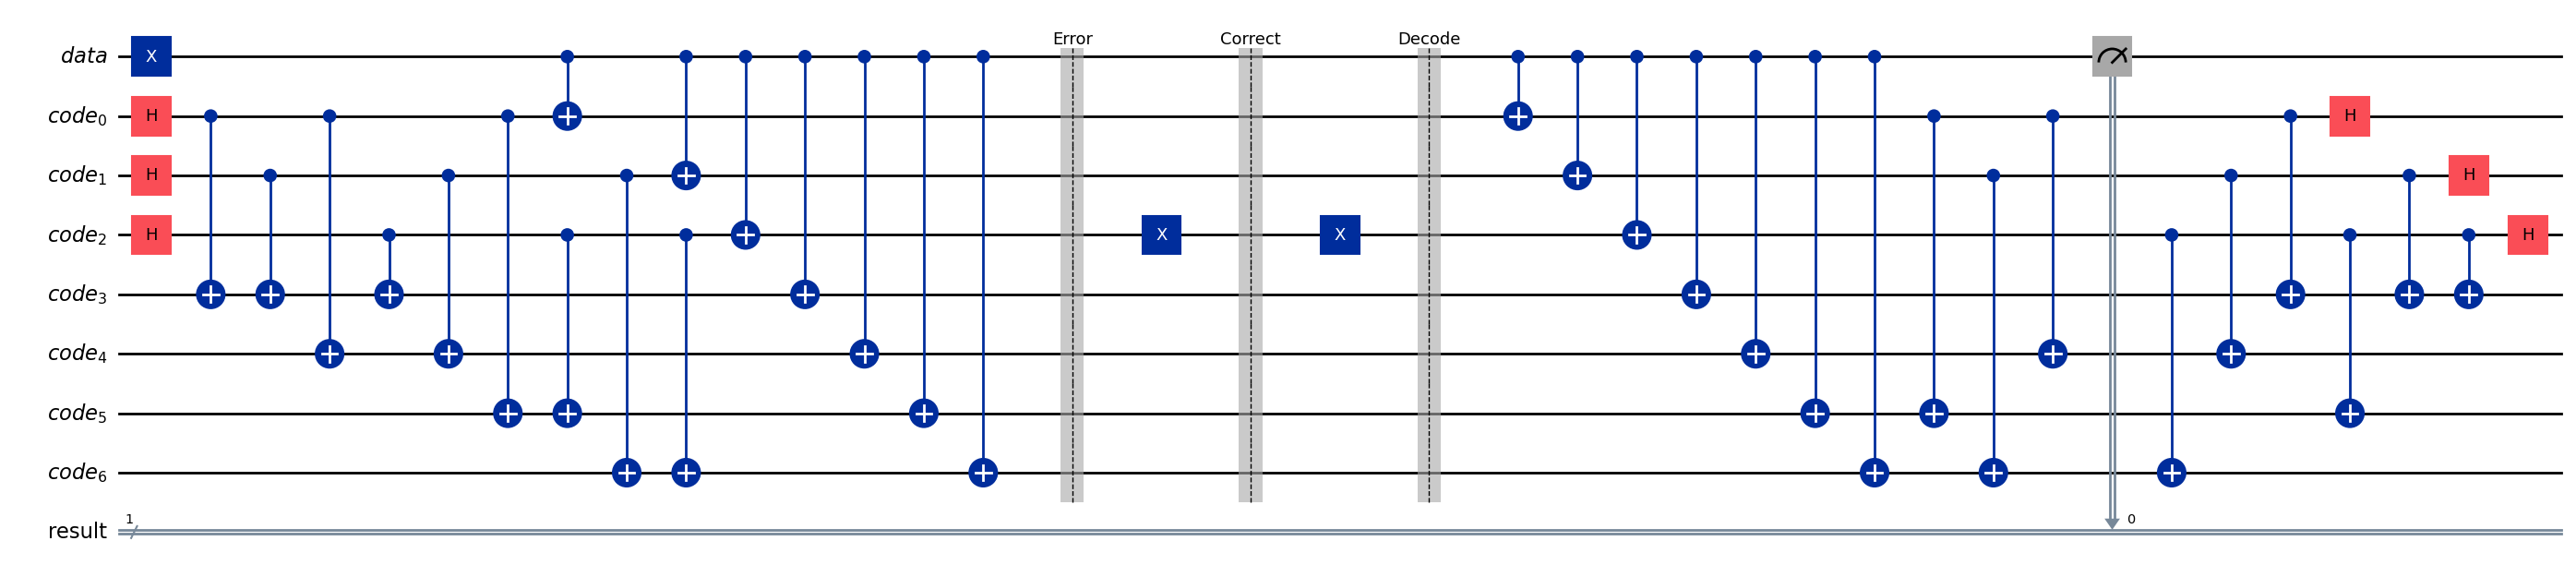

Circuit depth: 25
Total gates: 45


In [12]:
# ============================================================================
# CIRCUIT VISUALIZATION
# ============================================================================

from IPython.display import display
import matplotlib.pyplot as plt

# Create example circuit
data = QuantumRegister(1, 'data')
code = QuantumRegister(7, 'code')
result = ClassicalRegister(1, 'result')

qc = QuantumCircuit(data, code, result)
qc.x(data[0])

code_idx = [i + 1 for i in range(7)]
steane_encode(qc, data[0], code_idx)
qc.barrier(label='Error')

qc.x(code_idx[2])  # Example X error
qc.barrier(label='Correct')

qc.x(code_idx[2])  # Correction
qc.barrier(label='Decode')

steane_decode(qc, data[0], code_idx)
qc.measure(data[0], result[0])

fig = qc.draw(output="mpl", style='iqx', fold=100)
plt.title("Steane Code: Encode → Error → Correct → Decode")
display(fig)
plt.close('all')

print("Circuit depth:", qc.depth())
print("Total gates:", sum(1 for _ in qc.data))
